In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import gym
from gym import spaces
import numpy as np
import torch
import matplotlib.pyplot as plt
from tianshou.data import Batch

In [3]:
import tianshou
from typing import Any, Callable, List, Optional, Tuple, Union, Dict
from tianshou.data import Batch
from tianshou.env import DummyVectorEnv
from tianshou.data import Batch, ReplayBuffer, to_torch, to_torch_as
from tianshou.policy import BasePolicy

from tianshou.env.worker import (
    DummyEnvWorker,
    EnvWorker,
    RayEnvWorker,
    SubprocEnvWorker,
)

In [4]:
from env.VRPEnv import VRPEnv
from get_graphs import OSM_graph

In [5]:
from nets.attention_model import AttentionModel

In [6]:
import sys
from torch.utils.data import DataLoader, Dataset

In [7]:
## Working of the class OSM_graph, check DONE!!
osm_graph = OSM_graph()
graphs = osm_graph.generate_graphs(address="Berlin", shop_type="supermarket", graph_size=10, n_instances=5)

Total 864 points found on the map for search query: ('Berlin', 'supermarket')


In [8]:
## Initialize the dummy tour
tours = torch.tensor([[ 2,  1,  4,  3,  0,  9,  8,  0,  7,  6,  0,  5],
        [ 9,  1,  0,  6,  2,  7,  8,  5,  0,  3,  4,  0],
        [ 9,  5,  7,  3,  4,  0,  1,  2,  6,  0,  8,  0],
        [ 1,  5,  3,  8,  0,  6,  2,  4,  9,  0,  7,  0],
        [ 1,  9,  3,  2,  0,  5,  8,  7,  0,  6,  0,  4]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2 1 4 3]
tensor([[13.3371, 52.4713],
        [13.3053, 52.5126],
        [13.3330, 52.4696],
        [13.3203, 52.4711]])
[9 8]
tensor([[13.3931, 52.5054],
        [13.3400, 52.5230]])
[7 6]
tensor([[13.3788, 52.4925],
        [13.2908, 52.6329]])
[5]
tensor([[13.3948, 52.4894]])
[9 1]
tensor([[13.4414, 52.5438],
        [13.2091, 52.5576]])
[6 2 7 8 5]
tensor([[13.3121, 52.4987],
        [13.3838, 52.5038],
        [13.5579, 52.5068],
        [13.3353, 52.5948],
        [13.3098, 52.4794]])
[3 4]
tensor([[13.4057, 52.4041],
        [13.3003, 52.5075]])
[9 5 7 3 4]
tensor([[13.4488, 52.4220],
        [13.5357, 52.5110],
        [13.3028, 52.4271],
        [13.5165, 52.4612],
        [13.4988, 52.5605]])
[1 2 6]
tensor([[13.3466, 52.4293],
        [13.5872, 52.5214],
        [13.4148, 52.5192]])
[8]
tensor([[13.4429, 52.5434]])
[1 5 3 8]
tensor([[13.5096, 52.4046],
        [13.4164, 52.5407],
        [13.4275, 52.4752],
        [13.1555, 52.5327]])
[6 2 4 9]
tensor([[13.3854, 52.4841],

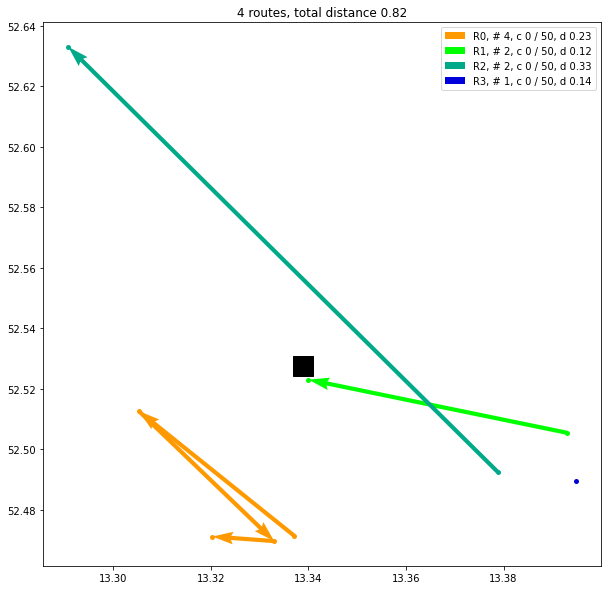

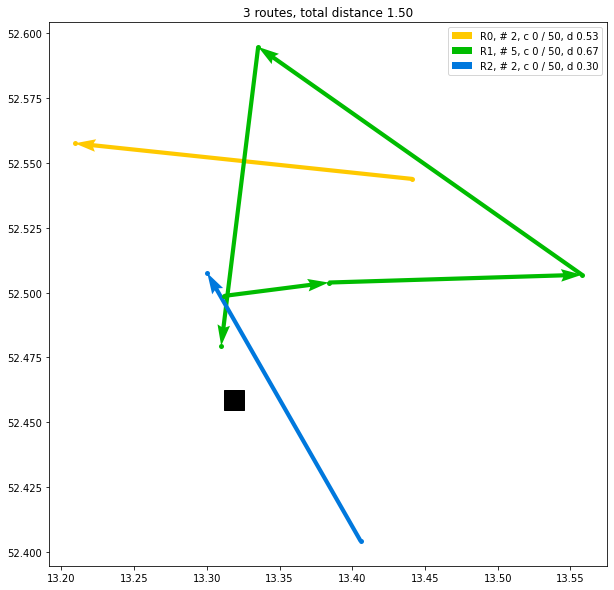

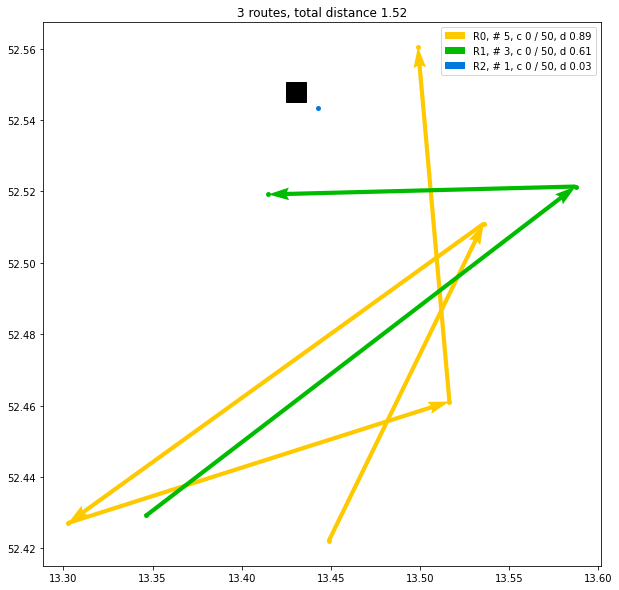

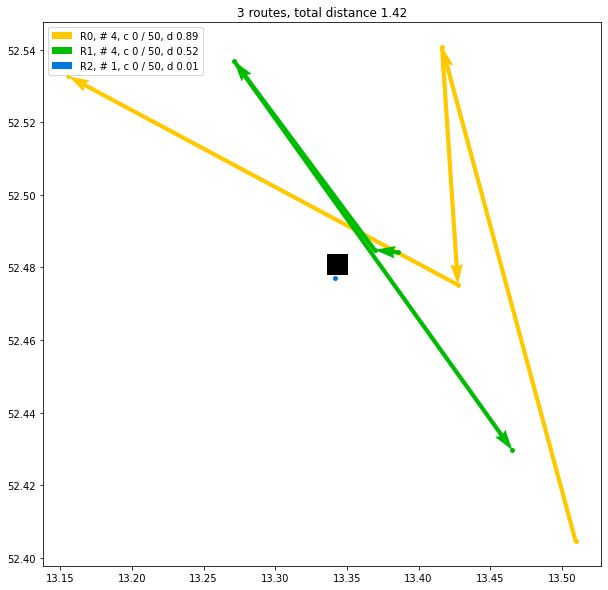

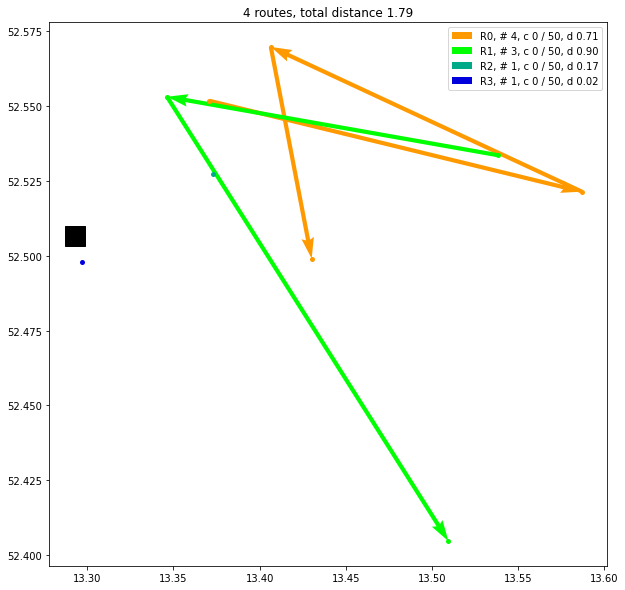

In [9]:
## Test the render with dummy tour, check DONE !!
test_env = VRPEnv(graphs[0], 0).render(graphs, tours)

In [31]:
class VRPDataset(Dataset):  
        
    def __init__(self, graph_size=10, n_instances=5, address="Berlin", shop_type="supermarket"):
      #super().__init__()
      self.vrpdataset = generate_graphs(address, shop_type, graph_size, n_instances)
    
    def __len__(self):
      return len(self.vrpdataset)

    def __getitem__(self, index):
        data = self.vrpdataset[index]
        return data

    def sample_graphs_viz(self, n_sample=5):
        sampled_graphs = random.sample(self.vrpdataset, n_sample)
        
        # define subplot grid
        fig, axs = plt.subplots(nrows=n_sample, ncols=1, figsize=(6,20))
        plt.subplots_adjust(hspace=0.5)
        fig.suptitle(f"Sampled {n_sample} graphs from the dataset", fontsize=16, y=0.95)
        
        # loop through graphs and axes
        s_idx = 0
        labels = [f"c_{i}" for i in range(len(sampled_graphs[0]["coordinates"]))]
        labels[0] = "depot"
        for graph, ax in zip(sampled_graphs, axs.ravel()):
            longitudes = [coord[0] for coord in graph["coordinates"]]
            latitudes = [coord[1] for coord in graph["coordinates"]]
            # filter df for ticker and plot on specified axes
            ax.scatter(longitudes, latitudes)

            # chart formatting
            s_idx += 1
            ax.set_title(f"Sample {s_idx}")
            ax.set_xlabel("longitudes")
            ax.set_ylabel("latitudes")

            for i, txt in enumerate(labels):
                ax.annotate(txt, (longitudes[i], latitudes[i]))

        plt.show()

In [13]:
#dataset = VRPDataset(graph_size=10, n_instances=3)

In [10]:
env_fns = [lambda instance=graph, idx=i: VRPEnv(instance, idx) for i,graph in enumerate(graphs)]

In [11]:
test_envs = DummyVectorEnv(env_fns)

In [34]:
train_envs = DummyVectorEnv(env_fns)

In [41]:
train_envs.reset()

Env: 0 reset
Env: 1 reset
Env: 2 reset
Env: 3 reset
Env: 4 reset


array([{'node_features': tensor([[ 1.0000,  0.0000,  0.0000, 13.3365, 52.5008],
               [ 0.0000,  1.0000,  0.1111, 13.3481, 52.5524],
               [ 0.0000,  1.0000,  0.1111, 13.1555, 52.5327],
               [ 0.0000,  1.0000,  0.1111, 13.4301, 52.5332],
               [ 0.0000,  1.0000,  0.1111, 13.3086, 52.5067],
               [ 0.0000,  1.0000,  0.1111, 13.1948, 52.5283],
               [ 0.0000,  1.0000,  0.1111, 13.4968, 52.5356],
               [ 0.0000,  1.0000,  0.1111, 13.2945, 52.4454],
               [ 0.0000,  1.0000,  0.1111, 13.4459, 52.5533],
               [ 0.0000,  1.0000,  0.1111, 13.3066, 52.5234]]), 'edge_features': tensor([[    0.0000,  7817.3999, 14455.5996,  8114.5000,  2804.8000, 11919.0996,
                12908.4004,  7881.3999, 10966.7002,  4281.7998],
               [ 7299.6001,     0.0000, 16265.2002,  8233.2002,  7441.0000, 12823.5996,
                12241.4004, 16571.5996,  7365.1001,  5509.6001],
               [14222.2998, 15388.4004,     

In [17]:
model = AttentionModel(
        embedding_dim=64,
        hidden_dim=16,
        n_encode_layers=2,
        tanh_clipping=10.,
        mask_inner=True, #to be fixed
        mask_logits=True,
        normalization='batch',
        n_heads=8,
        checkpoint_encoder=False,
        shrink_size=None
    )

#print(model)

##print(obs['demand'][obs['ids'], :] + obs['used_capacity'][0][:, :, None] > obs['capacity'] )
#action = model.forward(obs)
#print(action)

In [18]:
class REINFORCEPolicy(BasePolicy):
    """Implementation of REINFORCE algorithm."""
    def __init__(self, model: torch.nn.Module, optim: torch.optim.Optimizer,):
        super().__init__()
        self.actor = model
        self.optim = optim
        # action distribution
        self.dist_fn = torch.distributions.Categorical

        
    def forward(self, batch: Batch) -> Batch:
        """Compute action over the given batch data."""
        logits = self.actor(batch)
        #print(f"logits: {logits}")
        dist = self.dist_fn(logits=logits)
        #print(dist.probs)
        act = self.get_actions(dist, batch)
        #print(batch["action_mask"])
        #print(batch["remaining_capacity"])
        #print(act)
        return Batch(act=act, dist=dist)


    def process_fn(self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray) -> Batch:
        """Compute the discounted returns for each transition."""
        returns, _ = self.compute_episodic_return(batch, buffer, indices, gamma=0.99, gae_lambda=1.0)
        batch.returns = returns
        print(f"pre-batch: {batch}")
        return batch


    def learn(self, batch: Batch, batch_size: int, repeat: int) -> Dict[str, List[float]]:
        """Perform the back-propagation."""
        logging_losses = []
        for _ in range(repeat):
            for minibatch in batch.split(batch_size, merge_last=True):
                self.optim.zero_grad()
                result = self(minibatch)
                dist = result.dist
                act = to_torch_as(minibatch.act, result.act)
                ret = to_torch(minibatch.returns, torch.float, result.act.device)
                log_prob = dist.log_prob(act).reshape(len(ret), -1).transpose(0, 1)
                loss = -(log_prob * ret).mean()
                loss.backward()
                self.optim.step()
                logging_losses.append(loss.item())
        return {"loss": logging_losses}
    
    
    def get_actions(self, dist, batch_obs):
        actions = []
        for idx, (probs, mask) in enumerate(zip(dist.probs, batch_obs["action_mask"])):
            demands = batch_obs["node_features"][idx,:,2]
            mask_tensor = ~torch.tensor(mask, dtype=torch.bool)
            
            action_order = np.array(torch.topk(probs, 3).indices)
            
            #print(probs)
            #print(action_order)
            
            n = int(action_order.shape[1])
            
            action = int(action_order[0,0])
            
            if action == 0: #If selected node is depot node, confirm if any step is possible to next probable node
                alt_action = int(action_order[0,1])
                if demands[alt_action] <= batch_obs["remaining_capacity"][idx]:
                    action = alt_action
                    
            if batch_obs["remaining_capacity"][idx] < demands[action]:
                action = 0
                    
            #print(action)
            actions.append(action)
        actions = torch.tensor(actions).view(-1, 1)
        return actions


In [19]:
optim = torch.optim.Adam(model.parameters(), lr=0.0003)
VRPpolicy = REINFORCEPolicy(model, optim)

C:\Users\Jatin\anaconda3\lib\site-packages\numba\np\arraymath.py:3806: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)
C:\Users\Jatin\anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\Jatin\anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: h

In [20]:
#print(VRPpolicy)
#print("========================================")
#for para in VRPpolicy.parameters():
    #print(para.shape)

C:\Users\Jatin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
init_obs = Batch(test_envs.reset())

Env: 0 reset
Env: 1 reset
Env: 2 reset
Env: 3 reset
Env: 4 reset


In [22]:
action = VRPpolicy(init_obs)
print(action)

KeyError: 'obs'

In [ ]:
#test_envs.reset()
#result = test_envs.step(action.act)
#obs_next, rew, done, info = result
#obs_next = Batch(obs_next)
#
#print(obs_next["action_mask"])
#print(obs_next["curr_pos_idx"])

In [ ]:
test_envs.reset()
obs_next = init_obs
for _ in range(10):
    print("\n------------------------------------------------")
    action2 = VRPpolicy(obs_next)
    result2 = test_envs.step(action2.act)
    obs_next, rew, done, info = result2
    obs_next = Batch(obs_next)
    print(obs_next["action_mask"])
    #print(obs_next["curr_pos_idx"])

In [ ]:
print(obs_next)

In [ ]:
init_obs

In [ ]:
from data.VRPCollector import Collector

In [ ]:
from tianshou.data import VectorReplayBuffer
buffer_size = 100
replaybuffer = VectorReplayBuffer(buffer_size, buffer_num=5)


#test_collector = Collector(VRPpolicy, test_envs, replaybuffer)

In [ ]:
test_collector = Collector(VRPpolicy, test_envs)
train_collector = Collector(VRPpolicy, train_envs, replaybuffer)

In [ ]:
#print(replaybuffer["obs_next"])

In [ ]:
collect_result = test_collector.collect(n_episode=10)
print(collect_result)
print("Rewards of all environments are {}".format(collect_result["rews"]))
print("Average episode reward is {}.".format(collect_result["rew"]))
print("Average episode length is {}.".format(collect_result["len"]))

In [ ]:
#replaybuffer.sample(9)

#test_collector = Collector(VRPpolicy, test_envs, replaybuffer)

In [ ]:
from tianshou.trainer import onpolicy_trainer

train_collector.reset()
train_envs.reset()
test_collector.reset()
test_envs.reset()
replaybuffer.reset()

result = onpolicy_trainer(
    VRPpolicy,
    train_collector,
    test_collector,
    max_epoch=10,
    step_per_epoch=10,
    repeat_per_collect=1,
    episode_per_test=1,
    episode_per_collect=10,
    batch_size=5,
)

print(result)

In [ ]:
result